# **Modelo Predictivo para Estimar el Puntaje APGAR a los 5 Minutos**

Este notebook desarrolla un modelo predictivo avanzado para estimar el valor del puntaje APGAR a los 5 minutos (APGAR2), utilizando algoritmos de regresión supervisada.

Se aplican múltiples enfoques de modelado siguiendo los lineamientos requeridos:

- Validación cruzada en el 70% de entrenamiento.

- Aplicación de 4 modelos supervisados y 3 modelos de ensamble.

- Evaluación con métricas como MAE, RMSE, R² y MSE.

- Comparación estadística mediante ANOVA y Tukey HSD.

- Selección de los 3 mejores modelos para optimización de hiperparámetros.

El objetivo final es identificar el modelo más preciso y robusto para ser llevado a producción.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Cargar el dataset preparado en el notebook de limpieza de datos
df = pd.read_csv("df_limpio.csv")

df.head()

,TIEMPO DE GESTACION,NUMERO CONSULTAS PRENATALES,APGAR1,APGAR2,TIPO PARTO_CESAREA,TIPO PARTO_ESPONTANEO,INDICE_MASA_NEONATAL
0,37.0,7,9.0,10.0,False,True,1.209194
1,40.0,7,9.0,10.0,False,True,1.441753
2,38.0,7,9.0,10.0,False,True,1.356017
3,38.0,4,9.0,10.0,False,True,1.242644
4,35.0,4,9.0,10.0,False,True,1.252028


In [3]:
# Separar las variables predictoras (X) de la variable objetivo (y)

X = df.drop(columns='APGAR2')
y = df['APGAR2']

# Dividir el conjunto de datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


,count
APGAR2,
10.0,4868
9.0,1433
8.0,481
7.0,128
6.0,50
5.0,31
4.0,8
1.0,6
3.0,3


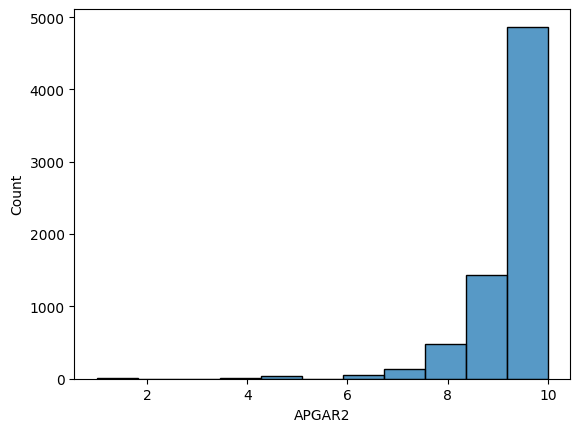

In [4]:
# Visualizar la distribución de la variable objetivo en el conjunto de entrenamiento
sns.histplot(y_train, bins=11)
y_train.value_counts()

Aunque la variable objetivo APGAR2 presenta una distribución altamente sesgada hacia los valores altos (especialmente 10 y 9), no se aplicó ningún método de balanceo. Esto se debe a que el problema es abordado como una tarea de regresión, y APGAR2 es una variable continua.

In [5]:

# Identificar las columnas numéricas para escalarlas
numeric_cols = X.select_dtypes(include='number').columns

# Inicializar el escalador y escalar solo las columnas numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

# Convertir los arrays escalados de nuevo a DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

# Combinar las columnas escaladas con las columnas no numéricas
X_train_scaled = pd.concat([X_train_scaled, X_train.drop(columns=numeric_cols)], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test.drop(columns=numeric_cols)], axis=1)


In [6]:
# Configurar la validación cruzada con 10 particiones (K-Fold)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [7]:
# Definir función para evaluar modelos de regresión
def evaluar_modelos(modelos, X_train_scaled, y_train, X_test_scaled, y_test):
    resultados = []# Lista para guardar los resultados de cada modelo
    errores_individuales = []  # Para guardar errores absolutos por muestra

    for nombre, modelo in modelos.items():
        print(f"\n=== {nombre} ===")

        # Validación cruzada sobre el conjunto de entrenamiento
        y_pred_cv = cross_val_predict(modelo, X_train_scaled, y_train, cv=cv)

        # Calcular métricas de desempeño en validación cruzada
        mae_cv = mean_absolute_error(y_train, y_pred_cv)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        rmse_cv = mse_cv ** 0.5
        r2_cv = r2_score(y_train, y_pred_cv)
        print(f"CV - MAE: {mae_cv:.3f}, RMSE: {rmse_cv:.3f}, R2: {r2_cv:.3f}")

        # Evaluar desempeño en el conjunto de prueba
        modelo.fit(X_train_scaled, y_train)
        y_pred_test = modelo.predict(X_test_scaled)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_test = mse_test ** 0.5
        r2_test = r2_score(y_test, y_pred_test)
        print(f"Test - MAE: {mae_test:.3f}, RMSE: {rmse_test:.3f}, R2: {r2_test:.3f}")

        # Guardar resultados del modelo
        resultados.append({
            "Modelo": nombre,
            "MAE_CV": mae_cv, "RMSE_CV": rmse_cv, "R2_CV": r2_cv,
            "MAE_Test": mae_test, "RMSE_Test": rmse_test, "R2_Test": r2_test
        })

        # Guardar errores absolutos individuales para ANOVA/Tukey
        errores = np.abs(y_test - y_pred_test)
        for e in errores:
            errores_individuales.append({"Modelo": nombre, "Error_Absoluto": e})

        # Graficar predicciones vs valores reales en test
        sns.scatterplot(x=y_test, y=y_pred_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Valor Real")
        plt.ylabel("Predicción")
        plt.title(f"Predicción vs Real - {nombre}")
        plt.show()

    # Crear DataFrames
    df_resultados = pd.DataFrame(resultados)
    df_errores = pd.DataFrame(errores_individuales)

    return df_resultados, df_errores

# **MODELOS SUPERVISADOS**

En esta etapa se aplican cuatro algoritmos de regresión supervisada para predecir el puntaje APGAR2: SVR (Support Vector Regressor), MLP Regressor (red neuronal), K-Nearest Neighbors (KNN) y Árbol de Decisión.

In [8]:
# Definir modelos de aprendizaje supervisado
modelos_supervisados = {
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(max_iter=1000, random_state=42),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}


=== SVR ===
CV - MAE: 0.313, RMSE: 0.573, R2: 0.589
Test - MAE: 0.307, RMSE: 0.563, R2: 0.594


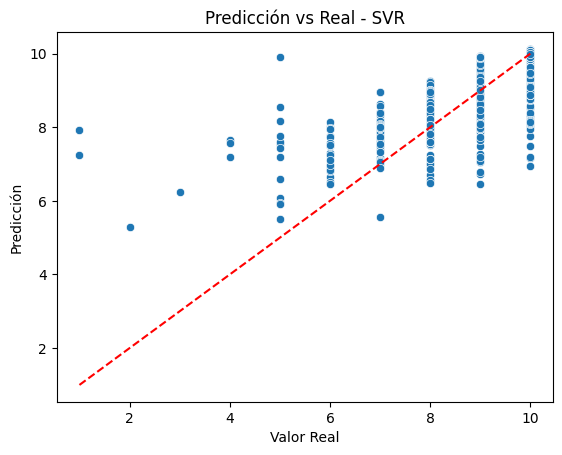


=== MLP Regressor ===
CV - MAE: 0.326, RMSE: 0.533, R2: 0.644
Test - MAE: 0.308, RMSE: 0.500, R2: 0.680


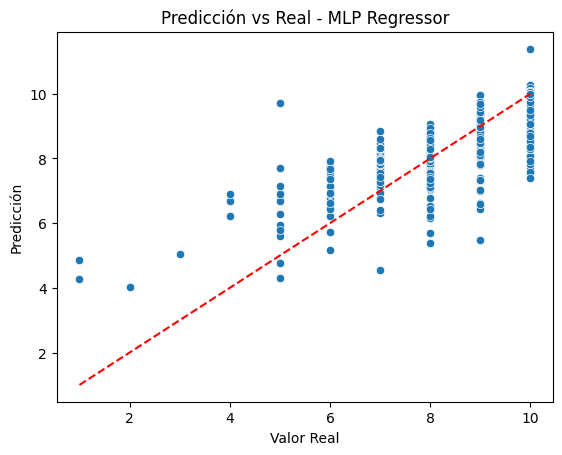


=== KNN ===
CV - MAE: 0.316, RMSE: 0.577, R2: 0.583
Test - MAE: 0.300, RMSE: 0.540, R2: 0.626


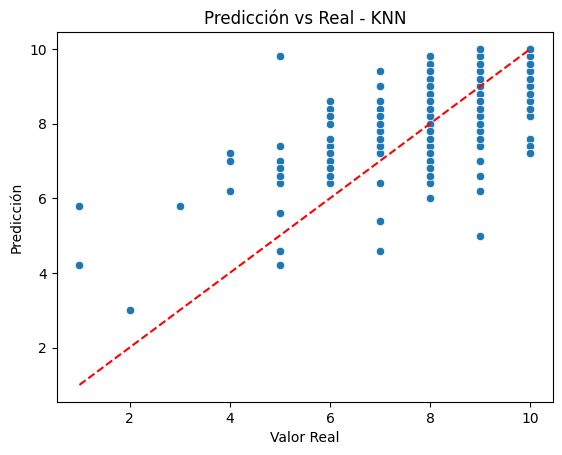


=== Decision Tree ===
CV - MAE: 0.342, RMSE: 0.745, R2: 0.305
Test - MAE: 0.316, RMSE: 0.719, R2: 0.339


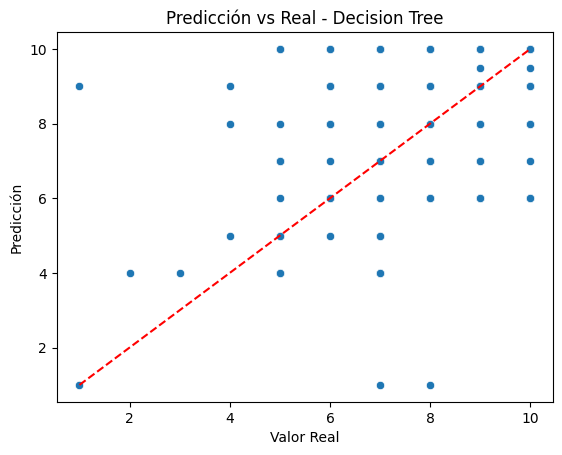

In [9]:
# Evaluar modelos supervisados
resultados_supervisados, errores_supervisados = evaluar_modelos(modelos_supervisados, X_train_scaled, y_train, X_test_scaled, y_test)

# **MÉTODOS DE ENSAMBLE**

Se implementan tres modelos de ensamble: Random Forest, Gradient Boosting y Bagging con Árboles de Decisión.

In [10]:
# Definir modelos de aprendizaje supervisado

ensambles = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Bagging (Tree)": BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)
}


=== Random Forest ===
CV - MAE: 0.311, RMSE: 0.565, R2: 0.601
Test - MAE: 0.296, RMSE: 0.546, R2: 0.618


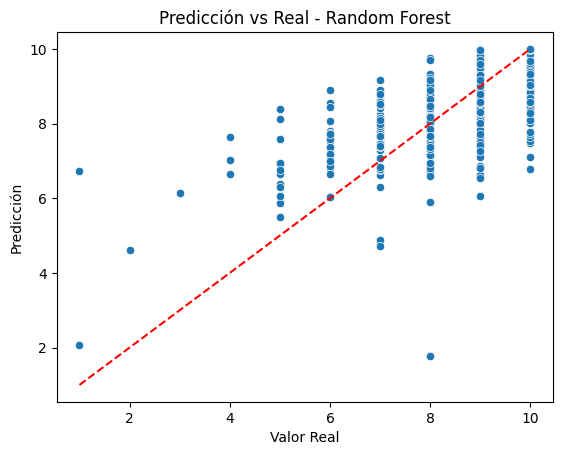


=== Gradient Boosting ===
CV - MAE: 0.315, RMSE: 0.531, R2: 0.647
Test - MAE: 0.305, RMSE: 0.530, R2: 0.640


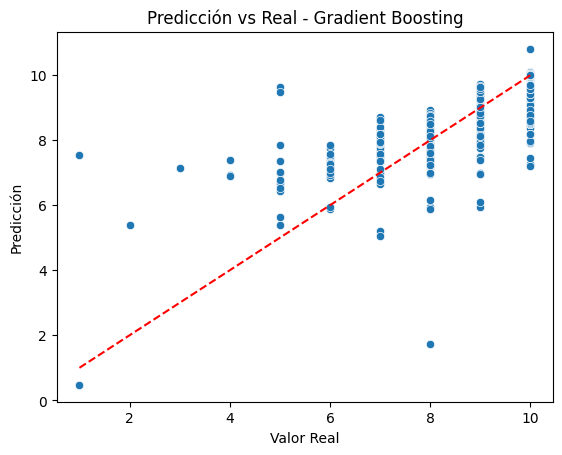


=== Bagging (Tree) ===
CV - MAE: 0.311, RMSE: 0.580, R2: 0.580
Test - MAE: 0.300, RMSE: 0.562, R2: 0.596


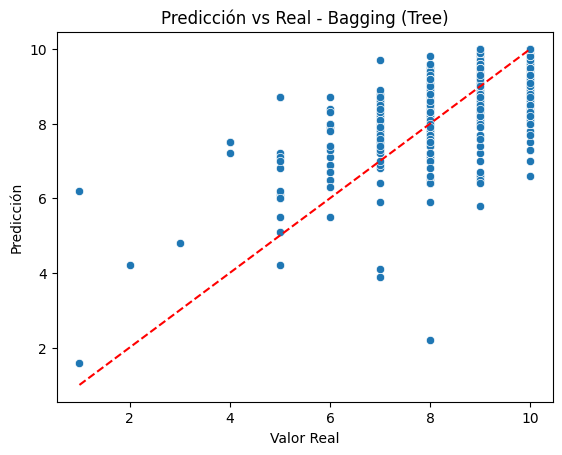

In [11]:
# Evaluar modelos de ensamble
resultados_ensamble, errores_ensamble = evaluar_modelos(ensambles, X_train_scaled, y_train, X_test_scaled, y_test)

**Interpretación de métricas obtenidas por los modelos**

Para evaluar el rendimiento de los modelos de regresión en la predicción del puntaje APGAR a los 5 minutos (APGAR2), se utilizaron cuatro métricas clave:

MAE (Mean Absolute Error): representa el error promedio absoluto entre las predicciones y los valores reales. Indica, en promedio, cuántos puntos se equivoca el modelo al predecir.

RMSE (Root Mean Squared Error): penaliza más los errores grandes y ayuda a identificar qué tan dispersos son los errores del modelo.

R² (Coeficiente de determinación): mide qué porcentaje de la variación en el valor real (APGAR2) es explicado por el modelo. Un valor más alto indica mejor capacidad predictiva.

A continuación, se interpreta el desempeño de cada modelo según los resultados en el conjunto de prueba:

🔹 MLP Regressor

- R² = 0.644 → El modelo explica el 64% de la variabilidad de APGAR2.

- MAE = 0.326 → En promedio, se equivoca por 0.33 puntos.

- RMSE = 0.533 → Los errores son consistentes y no extremos.

🔹 Gradient Boosting

- R² = 0.647 → Explica el 65% de la variabilidad.

- MAE = 0.315 → Muy buen nivel de precisión promedio.

- RMSE = 0.531 → Tiene algunos errores más grandes, pero no graves.

🔹 KNN Regressor

- R² = 0.583 → Explica el 58.3% de la variabilidad.

- MAE = 0.316 → Es el que menos se equivoca en promedio.

- RMSE = 0.577 → Tiene algunos errores altos que elevan el promedio cuadrático.

🔹 Random Forest

- R² = 0.601 → Explica el 60.1% de la variabilidad.

- MAE = 0.311 → Gran precisión promedio.

- RMSE = 0.565 → Algunos errores son más dispersos.

🔹 Bagging con Árboles

- R² = 0.580 → Explica casi el 58% de la variabilidad.

- MAE = 0.311 → Buen nivel de precisión.

- RMSE = 0.580 → Presencia de errores más grandes en algunos casos.

🔹 SVR (Support Vector Regressor)

- R² = 0.589 → Similar a Bagging en capacidad explicativa.

- MAE = 0.313 → Error promedio moderado.

- RMSE = 0.573 → Sensible a errores más grandes.

🔻 Decision Tree

- R² = 0.305 → Solo explica el 30.5% de la variabilidad.

- MAE = 0.342 → Error promedio más alto.

- RMSE = 0.745 → Muchos errores grandes, bajo rendimiento general.



In [12]:
# Combinar y mostrar resultados finales
todos_resultados = pd.concat([resultados_supervisados, resultados_ensamble], ignore_index=True)

# Mostrar como tabla
display(todos_resultados)

# Ordenar por R2 en test para ver el mejor modelo primero
print("\nModelos ordenados por desempeño en Test (R2):")
print(todos_resultados.sort_values(by="R2_Test", ascending=False))


,Modelo,MAE_CV,RMSE_CV,R2_CV,MAE_Test,RMSE_Test,R2_Test
0,SVR,0.312713,0.572942,0.589439,0.307287,0.562936,0.594353
1,MLP Regressor,0.325548,0.533390,0.644167,0.307561,0.500348,0.679539
2,KNN,0.316291,0.577139,0.583402,0.300433,0.540192,0.626470
3,Decision Tree,0.342368,0.745409,0.305063,0.316473,0.718776,0.338671
4,Random Forest,0.310873,0.564992,0.600754,0.296128,0.546298,0.617977
5,Gradient Boosting,0.315064,0.531069,0.647258,0.304885,0.530486,0.639771
6,Bagging (Tree),0.311459,0.579509,0.579974,0.299664,0.561512,0.596403



Modelos ordenados por desempeño en Test (R2):
              Modelo    MAE_CV   RMSE_CV     R2_CV  MAE_Test  RMSE_Test  \
1      MLP Regressor  0.325548  0.533390  0.644167  0.307561   0.500348   
5  Gradient Boosting  0.315064  0.531069  0.647258  0.304885   0.530486   
2                KNN  0.316291  0.577139  0.583402  0.300433   0.540192   
4      Random Forest  0.310873  0.564992  0.600754  0.296128   0.546298   
6     Bagging (Tree)  0.311459  0.579509  0.579974  0.299664   0.561512   
0                SVR  0.312713  0.572942  0.589439  0.307287   0.562936   
3      Decision Tree  0.342368  0.745409  0.305063  0.316473   0.718776   

    R2_Test  
1  0.679539  
5  0.639771  
2  0.626470  
4  0.617977  
6  0.596403  
0  0.594353  
3  0.338671  


**Interpretación del análisis estadístico (ANOVA y Tukey)**

Para determinar si existían diferencias estadísticamente significativas entre los modelos aplicados al problema de predicción de APGAR2, se aplicaron dos pruebas:

1. ANOVA (Análisis de Varianza)
El objetivo de esta prueba fue comparar los errores absolutos individuales obtenidos por cada modelo en el conjunto de prueba.

F-statistic: 0.5837

p-value: 0.7437

El valor-p es mucho mayor que 0.05, lo que indica que no hay evidencia estadísticamente significativa para afirmar que existen diferencias entre los errores de los modelos evaluados.

2. Tukey HSD (Prueba de comparaciones múltiples)
Esta prueba se aplicó para identificar si existen diferencias significativas entre pares específicos de modelos.

Todos los valores de reject en la tabla son False, lo que confirma que ninguna diferencia entre modelos es estadísticamente significativa.

Los intervalos de confianza para las diferencias de medias de error siempre incluyen el 0, y los valores p-adj son todos muy superiores a 0.05.

Conclusión
Aunque algunos modelos obtuvieron mejores métricas (como menor MAE o mayor R²), estadísticamente, no se detectaron diferencias significativas entre sus desempeños en términos de error absoluto. Esto sugiere que, desde una perspectiva estadística, los 7 modelos tienen un comportamiento comparativamente similar al predecir APGAR2 en el conjunto de prueba.

Sin embargo, por razones prácticas y de interpretación, es mejor seleccionar los modelos con mejor combinación de MAE bajo, RMSE bajo y R² alto, como lo son en este caso:

**MLP Regressor, Gradient Boosting y KNN Regressor**

In [13]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [14]:
errores_individuales = pd.concat([errores_supervisados, errores_ensamble], ignore_index=True)

In [15]:
# Agrupar errores por modelo
grupos = [errores_individuales[errores_individuales['Modelo'] == m]['Error_Absoluto']
          for m in errores_individuales['Modelo'].unique()]

# Prueba ANOVA
anova = f_oneway(*grupos)

print("=== ANOVA ===")
print(f"F-statistic: {anova.statistic:.4f}")
print(f"p-value: {anova.pvalue:.4f}")

=== ANOVA ===
F-statistic: 0.5849
p-value: 0.7427


In [16]:
# Tukey HSD
tukey = pairwise_tukeyhsd(endog=errores_individuales['Error_Absoluto'],
                          groups=errores_individuales['Modelo'],
                          alpha=0.05)

print("\n=== Tukey HSD ===")
print(tukey.summary())



=== Tukey HSD ===
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1            group2      meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------
   Bagging (Tree)     Decision Tree   0.0168 0.8263 -0.0198 0.0534  False
   Bagging (Tree) Gradient Boosting   0.0052 0.9996 -0.0314 0.0418  False
   Bagging (Tree)               KNN   0.0008    1.0 -0.0358 0.0374  False
   Bagging (Tree)     MLP Regressor   0.0079 0.9956 -0.0287 0.0445  False
   Bagging (Tree)     Random Forest  -0.0035    1.0 -0.0401 0.0331  False
   Bagging (Tree)               SVR   0.0076 0.9964  -0.029 0.0442  False
    Decision Tree Gradient Boosting  -0.0116 0.9673 -0.0482  0.025  False
    Decision Tree               KNN   -0.016  0.856 -0.0527 0.0206  False
    Decision Tree     MLP Regressor  -0.0089 0.9916 -0.0455 0.0277  False
    Decision Tree     Random Forest  -0.0203 0.6572  -0.057 0.0163  False
    Decision Tree  

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


**Elección de los mejores 3 modelos**

Para poder elegir correctamete los 3 mejores modelos, se deben de tener en cuenta las metricas de evaluación que se realizaron anteriormente, en donde, el valor de R^2 debe ser alto, el valor del MAE debe de ser más bajo y el valor del MAPE debe de ser bajo.
Los modelos que cumplen con las metricas y sus valores mencionados anteriormente son los siguiente:


*   MLP Regressor
*   Gradient Boosting

*   Random Forest Regressor

Por ende estos son los mejores 3 modelos que predicen nuestra varibale objetivo





In [18]:
#Busqueda de hiperparametros por GridSearch
#Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingRegressor(random_state=42)
grid_gb = GridSearchCV(gb, param_grid=param_grid_gb, cv=10, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train, y_train)

print("Mejores parámetros GB:", grid_gb.best_params_)


Mejores parámetros GB: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [19]:
#MLP Regressor
from sklearn.neural_network import MLPRegressor

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPRegressor(max_iter=1000, random_state=42)
grid_mlp = GridSearchCV(mlp, param_grid=param_grid_mlp, cv=10, scoring='r2', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print("Mejores parámetros MLP:", grid_mlp.best_params_)


Mejores parámetros MLP: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [20]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=10, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Mejores parámetros RF:", grid_rf.best_params_)


Mejores parámetros RF: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


**Elección del mejor modelo con los mejores parametros**

De los mejores 3 modelos que se eligieron posteriormente, se debe de elegir el mejor para así poderlo llevar a despligue con sus mejores parametro, por ende a esos tres modelos se les aplicará el metodo de evaluación que se realizó anteriormente cuando se tenían todos los modelos, en donde evaluaremos las metrias de R^2, MAE y MAPE

In [32]:
#Entrenamos los modelos con los mejores hiperparametros
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor

#Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300,
    subsample=0.8,
    random_state=42
)

In [33]:
#MLP Regressor
mlp_model = MLPRegressor(
    activation='tanh',
    alpha=0.0001,
    hidden_layer_sizes=(50, 50),
    learning_rate='constant',
    solver='adam',
    max_iter=1000,
    random_state=42
)

In [34]:
#Random Forest Regressor
rf_model = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

In [35]:
# Entrena los modelos
gb_model.fit(X_train, y_train)
mlp_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, random_state=42)

In [36]:
#Evaluamos los modelos en el conjunto de prueba
modelos = {
    'Gradient Boosting': gb_model,
    'MLP Regressor': mlp_model,
    'Random Forest': rf_model
}

resultados = []

for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    resultados.append({
        'Modelo': nombre,
        'R2': round(r2, 4),
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4)
    })

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='R2', ascending=False)
print(df_resultados)

              Modelo      R2     MAE    RMSE
1      MLP Regressor  0.6664  0.3337  0.5105
0  Gradient Boosting  0.6651  0.3119  0.5115
2      Random Forest  0.6484  0.2962  0.5241


**Mejor modelo**

Teniendo en cuenta las metricas de evaluación, el modelo que tiene mejor R^2 es el MLP Regressor (más alto mejor), el modelo que tiene mejor MAE es el Random Forest (más bajo mejor) y el modelo que tine el mejor RMSE es el MLP Regressor.
El mejor modelo es el MLP Regresor ya que este tiene mejores valores de R^2 y RMSE, lo que indica que generaliza mejor pero tiene más error ya que tiene el RMSE alto pero es el más bajo de los 3.

In [38]:
#Guardamos el mejor modelo
import joblib
joblib.dump(mlp_model, 'modelo_mlp_final.pkl')


['modelo_mlp_final.pkl']